In [1]:
#  Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.ensemble import RandomForestRegressor

In [2]:
#  Load the Dataset
dataset = pd.read_csv('fifa_players.csv')
dataset.head()

,name,full_name,birth_date,age,height_cm,weight_kgs,positions,nationality,overall_rating,potential,...,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle
0,L. Messi,Lionel Andrés Messi Cuccittini,6/24/1987,31,170.18,72.1,"CF,RW,ST",Argentina,94,94,...,94,48,22,94,94,75,96,33,28,26
1,C. Eriksen,Christian Dannemann Eriksen,2/14/1992,27,154.94,76.2,"CAM,RM,CM",Denmark,88,89,...,89,46,56,84,91,67,88,59,57,22
2,P. Pogba,Paul Pogba,3/15/1993,25,190.50,83.9,"CM,CAM",France,88,91,...,82,78,64,82,88,82,87,63,67,67
3,L. Insigne,Lorenzo Insigne,6/4/1991,27,162.56,59.0,"LW,ST",Italy,88,88,...,84,34,26,83,87,61,83,51,24,22
4,K. Koulibaly,Kalidou Koulibaly,6/20/1991,27,187.96,88.9,CB,Senegal,88,91,...,15,87,88,24,49,33,80,91,88,87


In [3]:
# Handle Null Values by Replacing with Medians
# Calculate the median for specified columns and fill null values
median1 = dataset["value_euro"].median()
median2 = dataset["wage_euro"].median()
median3 = dataset["release_clause_euro"].median()
median4 = dataset["national_rating"].median()
median5 = dataset["national_jersey_number"].median()

dataset["value_euro"].replace(np.nan, median1, inplace=True)
dataset["wage_euro"].replace(np.nan, median2, inplace=True)
dataset["release_clause_euro"].replace(np.nan, median3, inplace=True)
dataset["national_rating"].replace(np.nan, median4, inplace=True)
dataset["national_jersey_number"].replace(np.nan, median5, inplace=True)


In [4]:
#  Remove Duplicates if any

dataset.duplicated().sum()

0

In [5]:
# Encode categorical variables
categorical_columns = ['nationality', 'preferred_foot', 'body_type', 'national_team', 'national_team_position']
for col in categorical_columns:
    if col in dataset.columns:
        dataset[col] = LabelEncoder().fit_transform(dataset[col].astype(str))

In [6]:
dataset.isnull().sum()

name                             0
full_name                        0
birth_date                       0
age                              0
height_cm                        0
weight_kgs                       0
positions                        0
nationality                      0
overall_rating                   0
potential                        0
value_euro                       0
wage_euro                        0
preferred_foot                   0
international_reputation(1-5)    0
weak_foot(1-5)                   0
skill_moves(1-5)                 0
body_type                        0
release_clause_euro              0
national_team                    0
national_rating                  0
national_team_position           0
national_jersey_number           0
crossing                         0
finishing                        0
heading_accuracy                 0
short_passing                    0
volleys                          0
dribbling                        0
curve               

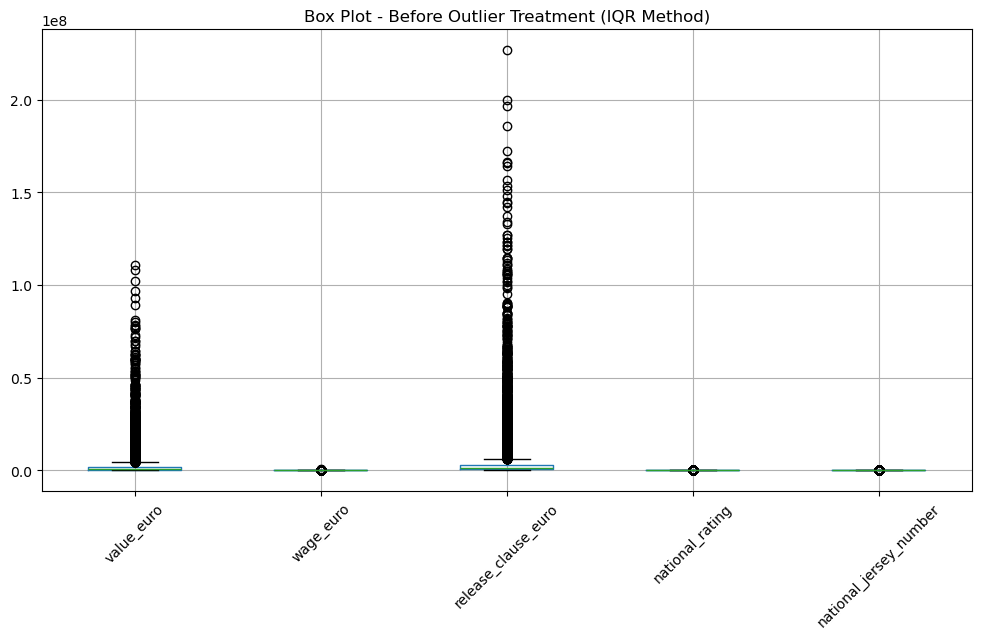

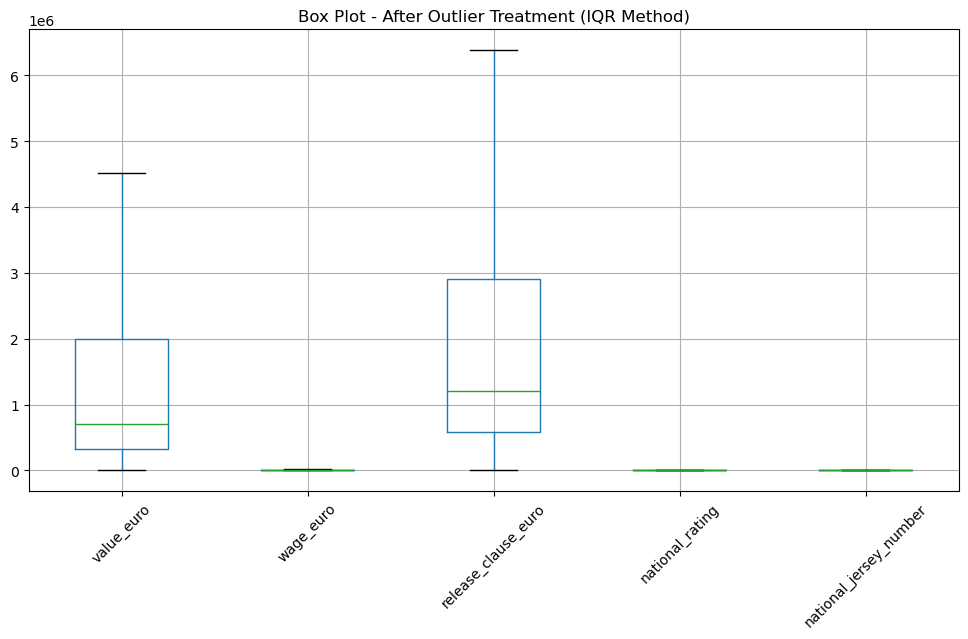

In [7]:
# Define the function to calculate IQR bounds
def remove_outlier(col):
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range, upper_range    

# List of columns to apply outlier treatment
outlier_columns = ['value_euro', 'wage_euro', 'release_clause_euro', 'national_rating', 'national_jersey_number']

# Box Plot Before Outlier Treatment
plt.figure(figsize=(12, 6))
dataset[outlier_columns].boxplot()
plt.title("Box Plot - Before Outlier Treatment (IQR Method)")
plt.xticks(rotation=45)
plt.show()

# Apply the IQR Outlier Treatment
for column in outlier_columns:
    lower_bound, upper_bound = remove_outlier(dataset[column])
    # Cap the outliers
    dataset[column] = np.where(dataset[column] > upper_bound, upper_bound, dataset[column])
    dataset[column] = np.where(dataset[column] < lower_bound, lower_bound, dataset[column])

#  Box Plot After Outlier Treatment
plt.figure(figsize=(12, 6))
dataset[outlier_columns].boxplot()
plt.title("Box Plot - After Outlier Treatment (IQR Method)")
plt.xticks(rotation=45)
plt.show()

In [8]:
# Standardize numerical features
numerical_features = dataset.select_dtypes(include=['float64', 'int64']).columns.tolist()
scaler = StandardScaler()
dataset[numerical_features] = scaler.fit_transform(dataset[numerical_features])


In [9]:
# Feature Engineering - Apply PCA for Dimensionality Reduction
# Apply PCA to reduce dimensionality to 10 components
pca = PCA(n_components=10)
X_pca = pca.fit_transform(dataset[numerical_features])

In [10]:
# Define target variable for regression
target_variable = 'overall_rating'
X = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
y = dataset[target_variable]

# Select the most correlated principal component for simple linear regression
correlations = [np.corrcoef(X[f'PC{i+1}'], y)[0, 1] for i in range(X.shape[1])]
best_pc = X.columns[np.argmax(np.abs(correlations))]
X_simple = X[[best_pc]]

In [11]:
#  Split Data for Regression
# Split data into train-test sets for regression models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_simple, X_test_simple = train_test_split(X_simple, test_size=0.2, random_state=42)


In [12]:
regressor_simple = LinearRegression()
regressor_simple.fit(X_train_simple, y_train)
y_pred_simple = regressor_simple.predict(X_test_simple)

In [13]:
# Evaluate Simple Linear Regression
simple_mse = mean_squared_error(y_test, y_pred_simple)
simple_r2 = r2_score(y_test, y_pred_simple)
print(f"Simple Linear Regression (1 PC) MSE: {simple_mse}, R2 Score: {simple_r2}")

Simple Linear Regression (1 PC) MSE: 0.6561736885713338, R2 Score: 0.3633398209047909


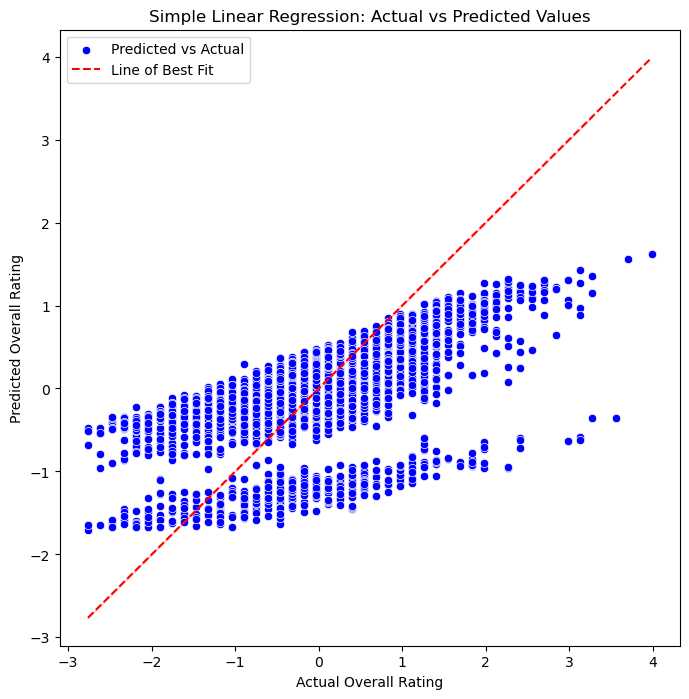

In [14]:
# Simple Linear Regression Plot
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred_simple, color='blue', label='Predicted vs Actual')
sns.lineplot(x=y_test, y=y_test, color='red', label='Line of Best Fit', linestyle='--')
plt.title('Simple Linear Regression: Actual vs Predicted Values')
plt.xlabel('Actual Overall Rating')
plt.ylabel('Predicted Overall Rating')
plt.legend()
plt.show()

In [15]:
#  Multiple Linear Regression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred_linear = regressor.predict(X_test)

# Evaluate Multiple Linear Regression
linear_mse = mean_squared_error(y_test, y_pred_linear)
linear_r2 = r2_score(y_test, y_pred_linear)
print(f"Multiple Linear Regression MSE: {linear_mse}, R2 Score: {linear_r2}")

Multiple Linear Regression MSE: 0.07623456917307565, R2 Score: 0.9260325195777793


In [16]:
# Assumption Checks for Multiple Linear Regression
X_train_sm = sm.add_constant(X_train)  # Add constant for statsmodels
model = sm.OLS(y_train, X_train_sm).fit()
residuals = y_test - y_pred_linear



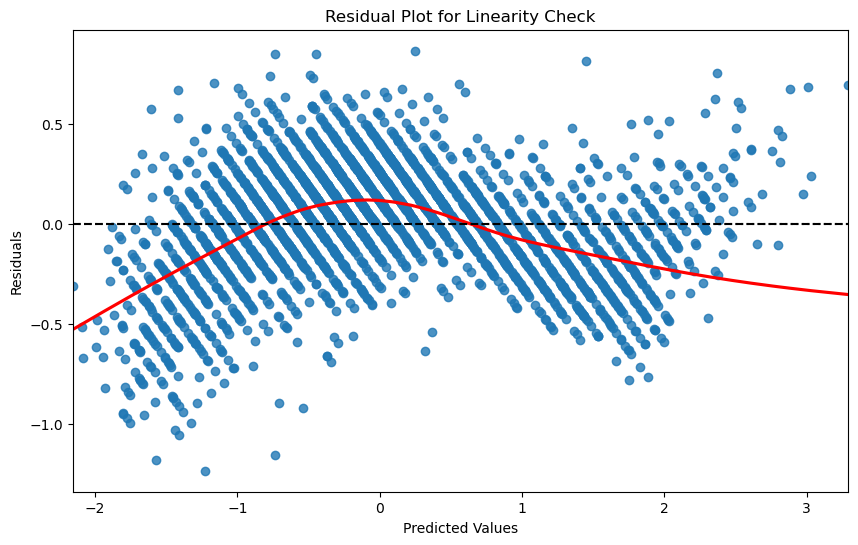

In [17]:
# 1. Linearity Check (Residual Plot)
plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred_linear, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot for Linearity Check")
plt.axhline(0, color='black', linestyle='--')
plt.show()


In [18]:
# 2. Autocorrelation (Durbin-Watson Test)
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson Statistic: {dw_stat}")

Durbin-Watson Statistic: 2.035575268139609


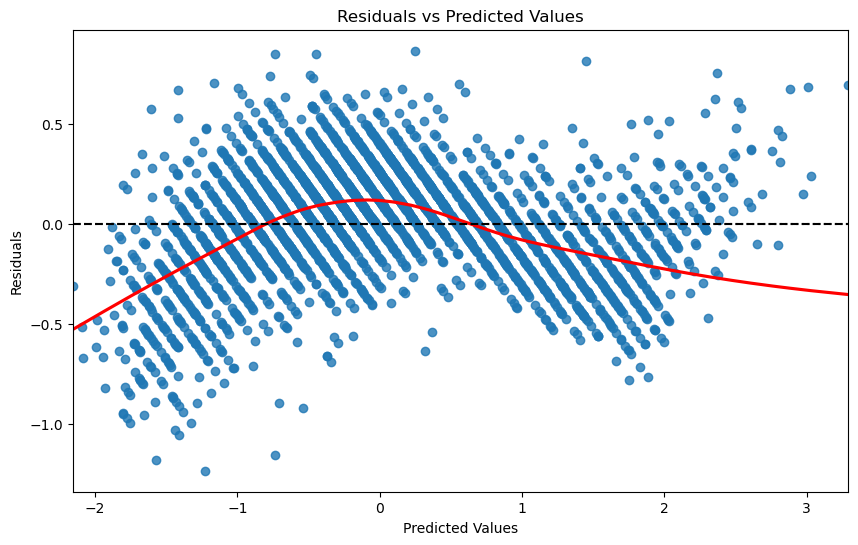

In [19]:
# 3. Homoscedasticity (Breusch-Pagan Test)
# Calculate residuals
residuals = y_test - y_pred_linear  # Ensure we use the correct predicted values from the multiple linear regression model

# Residual plot to visually inspect homoscedasticity
plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred_linear, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(0, color='black', linestyle='--')
plt.show()


In [20]:
# 4. No Perfect Multicollinearity (Variance Inflation Factor - VIF)
# Add a constant to X_train for VIF calculation
X_train_sm = sm.add_constant(X_train)  # Adds a constant to X_train for VIF calculation

# Calculate VIF for each feature in X_train_sm
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_sm.columns  # Ensures that features match those in X_train_sm, including the constant
vif_data["VIF"] = [variance_inflation_factor(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]

print("VIF Scores:\n", vif_data)


VIF Scores:
    Feature       VIF
0    const  1.000176
1      PC1  1.000141
2      PC2  1.000037
3      PC3  1.000282
4      PC4  1.000120
5      PC5  1.000149
6      PC6  1.000101
7      PC7  1.000049
8      PC8  1.000218
9      PC9  1.000293
10    PC10  1.000074


<Figure size 1000x600 with 0 Axes>

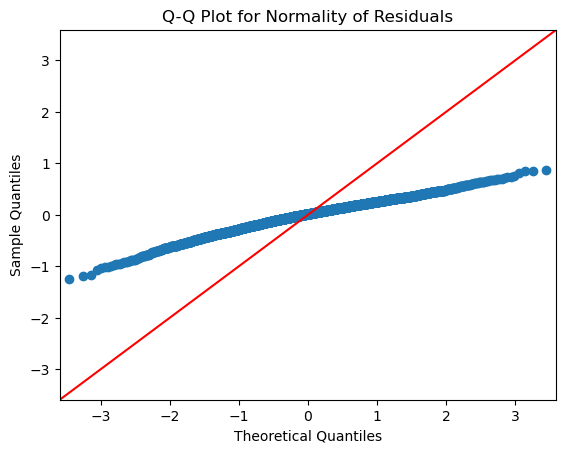

Shapiro-Wilk Test Statistic: 0.9864547848701477, p-value: 4.5783599044682215e-18


In [21]:
# 5. Normality of Errors (Q-Q Plot and Shapiro-Wilk Test)
plt.figure(figsize=(10, 6))
sm.qqplot(residuals, line='45')
plt.title("Q-Q Plot for Normality of Residuals")
plt.show()

shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk Test Statistic: {shapiro_test[0]}, p-value: {shapiro_test[1]}")


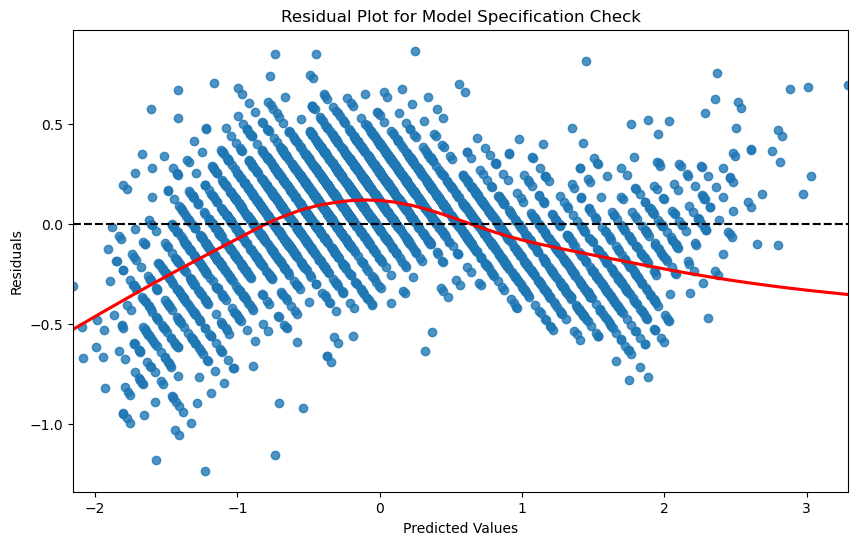

In [22]:
# 6. Model Specification Check (Residual Plot for Missing Predictors)
plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred_linear, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot for Model Specification Check")
plt.axhline(0, color='black', linestyle='--')
plt.show()


In [23]:
regressor_OLS = sm.OLS(endog = y, exog = X).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         overall_rating   R-squared (uncentered):                   0.924
Model:                            OLS   Adj. R-squared (uncentered):              0.924
Method:                 Least Squares   F-statistic:                          2.189e+04
Date:                Wed, 27 Nov 2024   Prob (F-statistic):                        0.00
Time:                        22:30:08   Log-Likelihood:                         -2312.4
No. Observations:               17954   AIC:                                      4645.
Df Residuals:                   17944   BIC:                                      4723.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
PC1           -0.1403      0.000   -290.717      0.000      -0.141      -0.139
PC2            0.2064      0.001    231.960      0.000       0.205       0.208
PC3            0.2679      0.001    258.393      0.000       0.266       0.270
PC4           -0.0998      0.001    -69.890      0.000      -0.103      -0.097
PC5            0.0392      0.002     22.799      0.000       0.036       0.043
PC6            0.1254      0.002     67.921      0.000       0.122       0.129
PC7           -0.0148      0.002     -6.578      0.000      -0.019      -0.010
PC8           -0.1457      0.002    -60.493      0.000      -0.150      -0.141
PC9            0.0232      0.003      9.148      0.000       0.018       0.028
PC10           0.0171      0.003      6.282      0.000       0.012       0.022
==============================================================================
Omnibus:                      592.450   Durbin-Watson:                   1.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              733.784
Skew:                          -0.390   Prob(JB):                    4.58e-160
Kurtosis:                       3.610   Cond. No.                         5.64
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

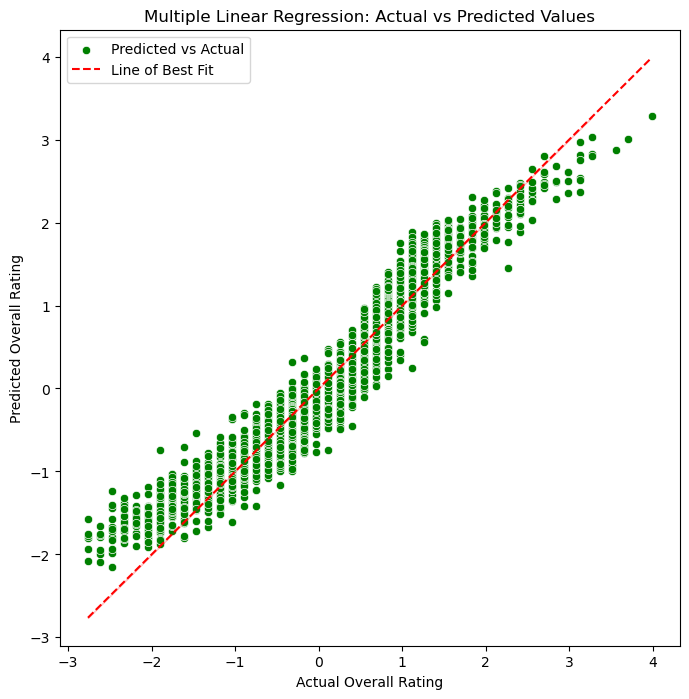

In [24]:
# Multiple Linear Regression Plot
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred_linear, color='green', label='Predicted vs Actual')
sns.lineplot(x=y_test, y=y_test, color='red', label='Line of Best Fit', linestyle='--')
plt.title('Multiple Linear Regression: Actual vs Predicted Values')
plt.xlabel('Actual Overall Rating')
plt.ylabel('Predicted Overall Rating')
plt.legend()
plt.show()

In [25]:
#  Polynomial Regression
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
regressor_poly = LinearRegression()
regressor_poly.fit(X_train_poly, y_train)
y_pred_poly = regressor_poly.predict(X_test_poly)


In [26]:
# Evaluate Polynomial Regression
poly_mse = mean_squared_error(y_test, y_pred_poly)
poly_r2 = r2_score(y_test, y_pred_poly)
print(f"Polynomial Regression MSE: {poly_mse}, R2 Score: {poly_r2}")

Polynomial Regression MSE: 0.04019251684357191, R2 Score: 0.9610027414728717


In [27]:
# Evaluate Polynomial Regression on Training Data
y_train_pred_poly = regressor_poly.predict(X_train_poly)
train_mse_poly = mean_squared_error(y_train, y_train_pred_poly)
train_r2_poly = r2_score(y_train, y_train_pred_poly)

# Evaluate Polynomial Regression on Test Data
y_test_pred_poly = regressor_poly.predict(X_test_poly)
test_mse_poly = mean_squared_error(y_test, y_test_pred_poly)
test_r2_poly = r2_score(y_test, y_test_pred_poly)

# Print Results
print(f"Polynomial Regression Training MSE: {train_mse_poly}, R2 Score: {train_r2_poly}")
print(f"Polynomial Regression Test MSE: {test_mse_poly}, R2 Score: {test_r2_poly}")

# Overfitting Check Interpretation
if train_mse_poly < test_mse_poly and (test_r2_poly < train_r2_poly):
    print("The model may be overfitting, as it performs significantly better on the training data than on the test data.")
else:
    print("No significant overfitting detected.")


Polynomial Regression Training MSE: 0.039148111366193526, R2 Score: 0.960547984245579
Polynomial Regression Test MSE: 0.04019251684357191, R2 Score: 0.9610027414728717
No significant overfitting detected.


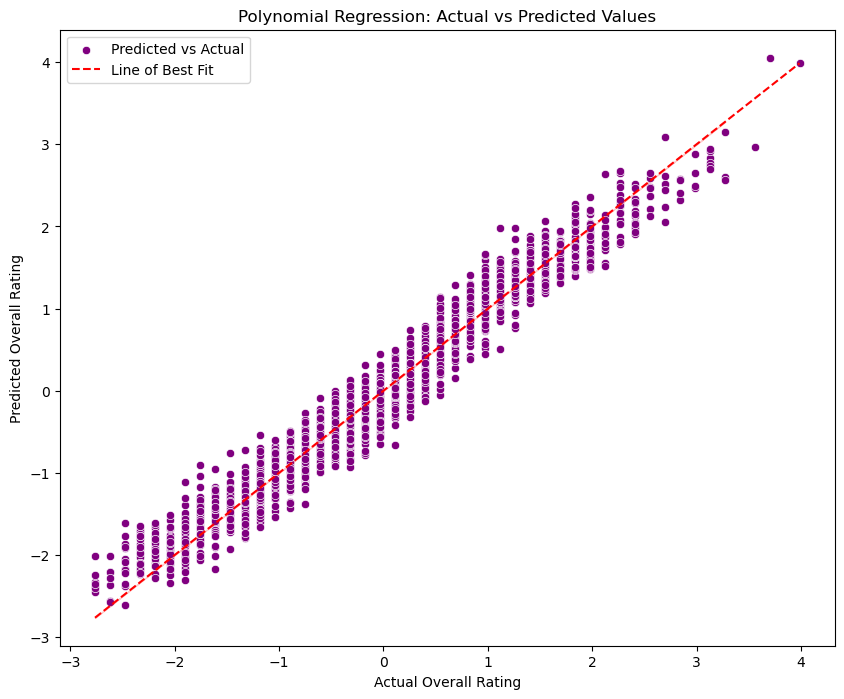

In [28]:
# Polynomial Regression Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_test, y=y_pred_poly, color='purple', label='Predicted vs Actual')
sns.lineplot(x=y_test, y=y_test, color='red', label='Line of Best Fit', linestyle='--')
plt.title('Polynomial Regression: Actual vs Predicted Values')
plt.xlabel('Actual Overall Rating')
plt.ylabel('Predicted Overall Rating')
plt.legend()
plt.show()

In [29]:
#Random Forest Regression
# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42)

# Train the Random Forest model on the training data
rf_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_regressor.predict(X_test)


In [30]:
# Evaluate the Random Forest Regression model
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)
print(f"Random Forest Regression MSE: {rf_mse}, R2 Score: {rf_r2}")

Random Forest Regression MSE: 0.03641068697079357, R2 Score: 0.9646721060421108


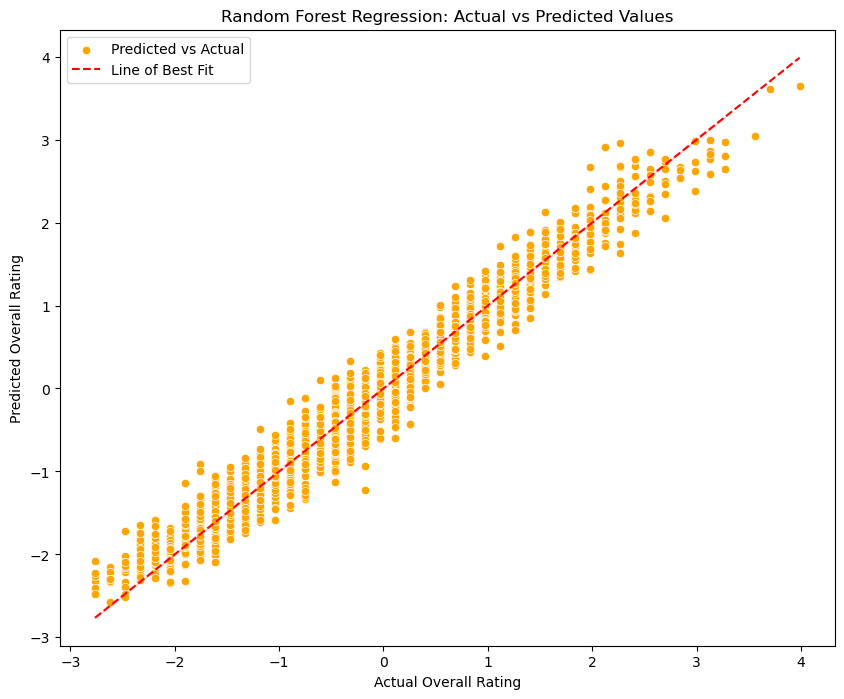

In [31]:
# Visualization of Random Forest Regression Results
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_test, y=y_pred_rf, color='orange', label='Predicted vs Actual')
sns.lineplot(x=y_test, y=y_test, color='red', label='Line of Best Fit', linestyle='--')
plt.title('Random Forest Regression: Actual vs Predicted Values')
plt.xlabel('Actual Overall Rating')
plt.ylabel('Predicted Overall Rating')
plt.legend()
plt.show()

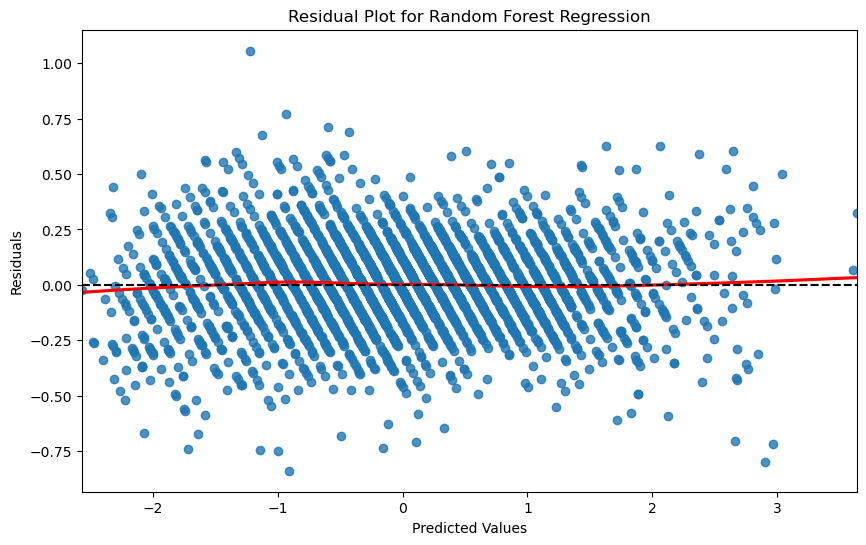

In [32]:
# Calculate residuals for Random Forest Regression
residuals_rf = y_test - y_pred_rf

# Residual plot to inspect the residuals for Random Forest Regression
plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred_rf, y=residuals_rf, lowess=True, line_kws={'color': 'red'})
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot for Random Forest Regression')
plt.axhline(0, color='black', linestyle='--')
plt.show()

In [33]:
#  Convert Continuous Target to Categorical for Classification
# Binning the continuous target variable into three categories
bins = [-np.inf, dataset['overall_rating'].mean() - dataset['overall_rating'].std(),
        dataset['overall_rating'].mean() + dataset['overall_rating'].std(), np.inf]
labels = ['Low', 'Medium', 'High']
dataset['overall_rating_category'] = pd.cut(dataset['overall_rating'], bins=bins, labels=labels)

# Define features and new classification target
X_class = X  # Use PCA-transformed features
y_class = dataset['overall_rating_category']

# Train-Test Split for Classification
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)



In [34]:
#  K-Nearest Neighbors (KNN)
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)  # k=5
knn.fit(X_train_class, y_train_class)
y_pred_knn = knn.predict(X_test_class)

# Evaluate KNN
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("KNN Classification Report:")
print(classification_report(y_test_class, y_pred_knn))
print("KNN Accuracy:", accuracy_score(y_test_class, y_pred_knn))


KNN Classification Report:
              precision    recall  f1-score   support

        High       0.87      0.86      0.86       516
         Low       0.89      0.83      0.86       589
      Medium       0.93      0.95      0.94      2486

    accuracy                           0.92      3591
   macro avg       0.90      0.88      0.89      3591
weighted avg       0.92      0.92      0.92      3591

KNN Accuracy: 0.9161793372319688


In [35]:
#  Decision Tree (DT)
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train_class, y_train_class)
y_pred_dt = dt.predict(X_test_class)

# Evaluate Decision Tree
print("Decision Tree Classification Report:")
print(classification_report(y_test_class, y_pred_dt))
print("Decision Tree Accuracy:", accuracy_score(y_test_class, y_pred_dt))

Decision Tree Classification Report:
              precision    recall  f1-score   support

        High       0.88      0.80      0.84       516
         Low       0.83      0.75      0.79       589
      Medium       0.90      0.94      0.92      2486

    accuracy                           0.89      3591
   macro avg       0.87      0.83      0.85      3591
weighted avg       0.89      0.89      0.89      3591

Decision Tree Accuracy: 0.8883319409635199


In [36]:
#  Logistic Regression (LR)
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_class, y_train_class)
y_pred_lr = lr.predict(X_test_class)

# Evaluate Logistic Regression
print("Logistic Regression Classification Report:")
print(classification_report(y_test_class, y_pred_lr))
print("Logistic Regression Accuracy:", accuracy_score(y_test_class, y_pred_lr))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

        High       0.88      0.91      0.89       516
         Low       0.88      0.88      0.88       589
      Medium       0.95      0.95      0.95      2486

    accuracy                           0.93      3591
   macro avg       0.90      0.91      0.91      3591
weighted avg       0.93      0.93      0.93      3591

Logistic Regression Accuracy: 0.9298245614035088


In [37]:
#  Random Forest (RF)
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_class, y_train_class)
y_pred_rf = rf.predict(X_test_class)

# Evaluate Random Forest
print("Random Forest Classification Report:")
print(classification_report(y_test_class, y_pred_rf))
print("Random Forest Accuracy:", accuracy_score(y_test_class, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

        High       0.88      0.89      0.88       516
         Low       0.89      0.87      0.88       589
      Medium       0.95      0.95      0.95      2486

    accuracy                           0.93      3591
   macro avg       0.91      0.90      0.90      3591
weighted avg       0.93      0.93      0.93      3591

Random Forest Accuracy: 0.9275967697020329


In [38]:
def plot_confusion_matrix(y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

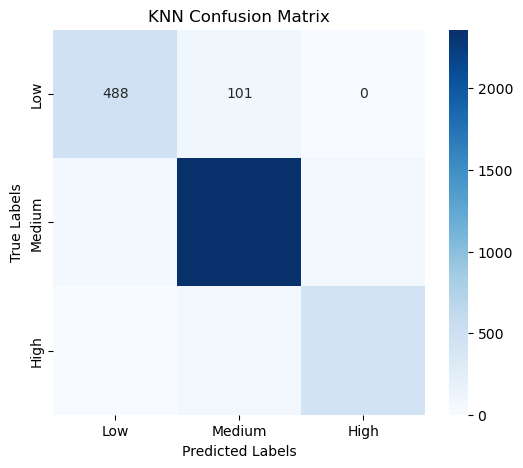

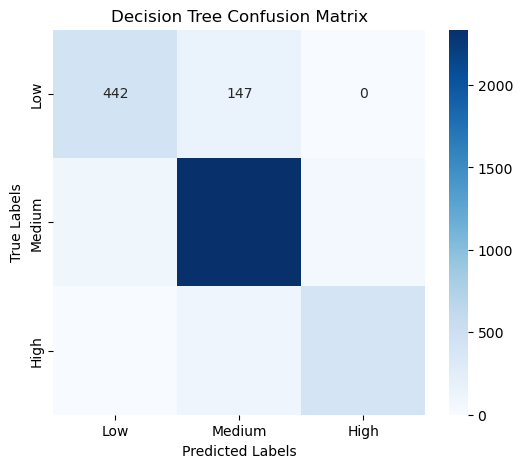

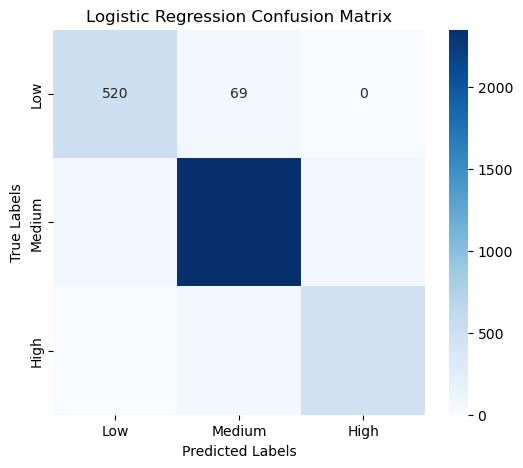

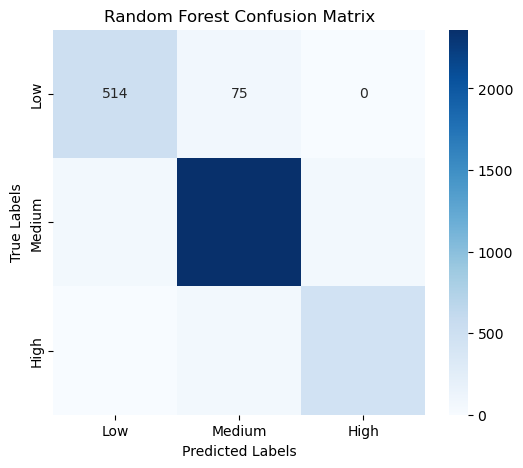

In [39]:
# Confusion Matrices
plot_confusion_matrix(y_test_class, y_pred_knn, "KNN Confusion Matrix")
plot_confusion_matrix(y_test_class, y_pred_dt, "Decision Tree Confusion Matrix")
plot_confusion_matrix(y_test_class, y_pred_lr, "Logistic Regression Confusion Matrix")
plot_confusion_matrix(y_test_class, y_pred_rf, "Random Forest Confusion Matrix")

                 Model       MAE       MSE        R²
0                  KNN  0.122807  0.200780  0.624727
1        Decision Tree  0.156781  0.247006  0.538326
2  Logistic Regression  0.101921  0.165414  0.690830
3        Random Forest  0.106377  0.174325  0.674174


<Figure size 1200x600 with 0 Axes>

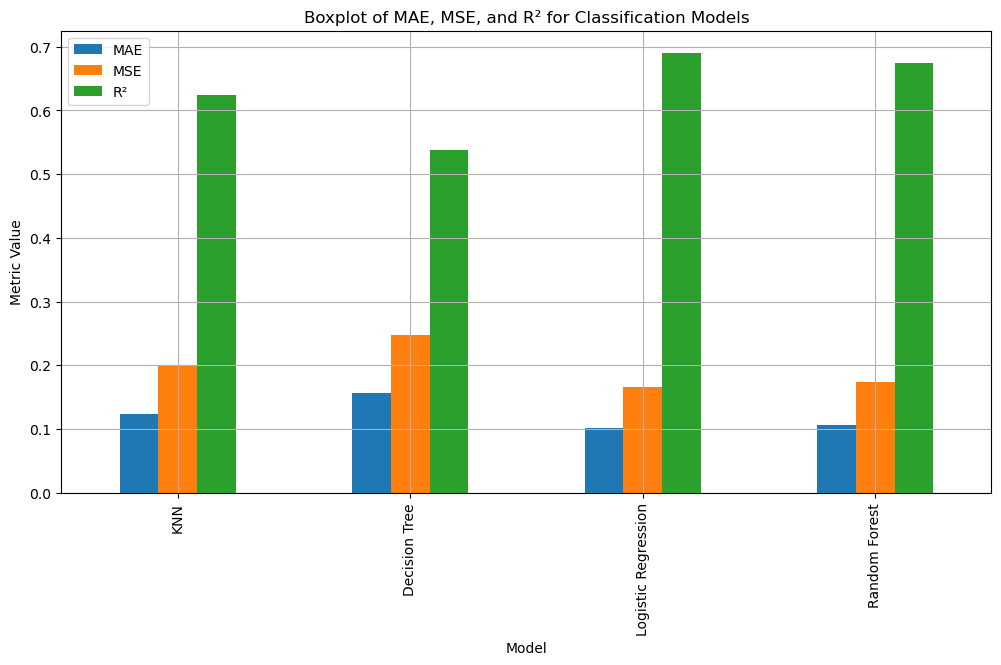

In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt

# Convert categorical variables to numeric using LabelEncoder
le = LabelEncoder()
y_test_class_numeric = le.fit_transform(y_test_class)
y_pred_knn_numeric = le.transform(y_pred_knn)
y_pred_dt_numeric = le.transform(y_pred_dt)
y_pred_lr_numeric = le.transform(y_pred_lr)
y_pred_rf_numeric = le.transform(y_pred_rf)

# Define a function to calculate and store metrics for each model
def evaluate_metrics(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"Model": model_name, "MAE": mae, "MSE": mse, "R²": r2}

# Evaluate metrics for each classification model
metrics = []
metrics.append(evaluate_metrics(y_test_class_numeric, y_pred_knn_numeric, "KNN"))
metrics.append(evaluate_metrics(y_test_class_numeric, y_pred_dt_numeric, "Decision Tree"))
metrics.append(evaluate_metrics(y_test_class_numeric, y_pred_lr_numeric, "Logistic Regression"))
metrics.append(evaluate_metrics(y_test_class_numeric, y_pred_rf_numeric, "Random Forest"))

# Convert metrics to a DataFrame for easy visualization
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

# Plot barplots for Comparison of MAE, MSE, and R²
plt.figure(figsize=(12, 6))
metrics_df.set_index("Model").plot(kind="bar", figsize=(12, 6), grid=True)
plt.title("Boxplot of MAE, MSE, and R² for Classification Models")
plt.ylabel("Metric Value")
plt.show()


In [46]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate metrics for classification models
metrics = {
    "KNN": {
        "Mean Absolute Error (MAE)": mean_absolute_error(y_test_class_numeric, y_pred_knn_numeric),
        "Mean Squared Error (MSE)": mean_squared_error(y_test_class_numeric, y_pred_knn_numeric),
        "Root Mean Squared Error (RMSE)": np.sqrt(mean_squared_error(y_test_class_numeric, y_pred_knn_numeric)),
        "R² Score": r2_score(y_test_class_numeric, y_pred_knn_numeric),
    },
    "Decision Tree": {
        "Mean Absolute Error (MAE)": mean_absolute_error(y_test_class_numeric, y_pred_dt_numeric),
        "Mean Squared Error (MSE)": mean_squared_error(y_test_class_numeric, y_pred_dt_numeric),
        "Root Mean Squared Error (RMSE)": np.sqrt(mean_squared_error(y_test_class_numeric, y_pred_dt_numeric)),
        "R² Score": r2_score(y_test_class_numeric, y_pred_dt_numeric),
    },
    "Logistic Regression": {
        "Mean Absolute Error (MAE)": mean_absolute_error(y_test_class_numeric, y_pred_lr_numeric),
        "Mean Squared Error (MSE)": mean_squared_error(y_test_class_numeric, y_pred_lr_numeric),
        "Root Mean Squared Error (RMSE)": np.sqrt(mean_squared_error(y_test_class_numeric, y_pred_lr_numeric)),
        "R² Score": r2_score(y_test_class_numeric, y_pred_lr_numeric),
    },
    "Random Forest": {
        "Mean Absolute Error (MAE)": mean_absolute_error(y_test_class_numeric, y_pred_rf_numeric),
        "Mean Squared Error (MSE)": mean_squared_error(y_test_class_numeric, y_pred_rf_numeric),
        "Root Mean Squared Error (RMSE)": np.sqrt(mean_squared_error(y_test_class_numeric, y_pred_rf_numeric)),
        "R² Score": r2_score(y_test_class_numeric, y_pred_rf_numeric),
    },
}

In [47]:
# Function to plot bar chart of metrics
def plot_metrics_bar(metrics_dict, model_name):
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(
        metrics_dict.keys(),
        metrics_dict.values(),
        color=["skyblue", "lightgreen", "coral", "violet"],
    )

    # Annotate bar values
    for bar in bars:
        value = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            value + 0.02,
            f"{value:.4f}",
            ha="center",
            fontsize=12,
            color="black",
        )

    ax.set_title(f"{model_name} Metrics", fontsize=16)
    ax.set_ylabel("Values", fontsize=12)
    ax.set_xticklabels(metrics_dict.keys(), fontsize=10, rotation=15)
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


In [48]:
# Function to plot predictions vs. actual values
def plot_predictions(y_test, y_pred, model_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(
        y_test, y_pred, color="blue", alpha=0.7, edgecolor="k", label="Predicted vs Actual"
    )
    plt.plot(
        [min(y_test), max(y_test)],
        [min(y_test), max(y_test)],
        color="red",
        linestyle="--",
        label="Perfect Fit",
    )
    plt.xlabel("Actual Values", fontsize=12)
    plt.ylabel("Predicted Values", fontsize=12)
    plt.title(f"{model_name}: Predicted vs Actual", fontsize=14)
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()

# Mapping model names to predictions for direct reference
model_predictions = {
    "KNN": y_pred_knn_numeric,
    "Decision Tree": y_pred_dt_numeric,
    "Logistic Regression": y_pred_lr_numeric,
    "Random Forest": y_pred_rf_numeric,
}


C:\Users\Arnav\AppData\Local\Temp\ipykernel_11000\1666008591.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(metrics_dict.keys(), fontsize=10, rotation=15)


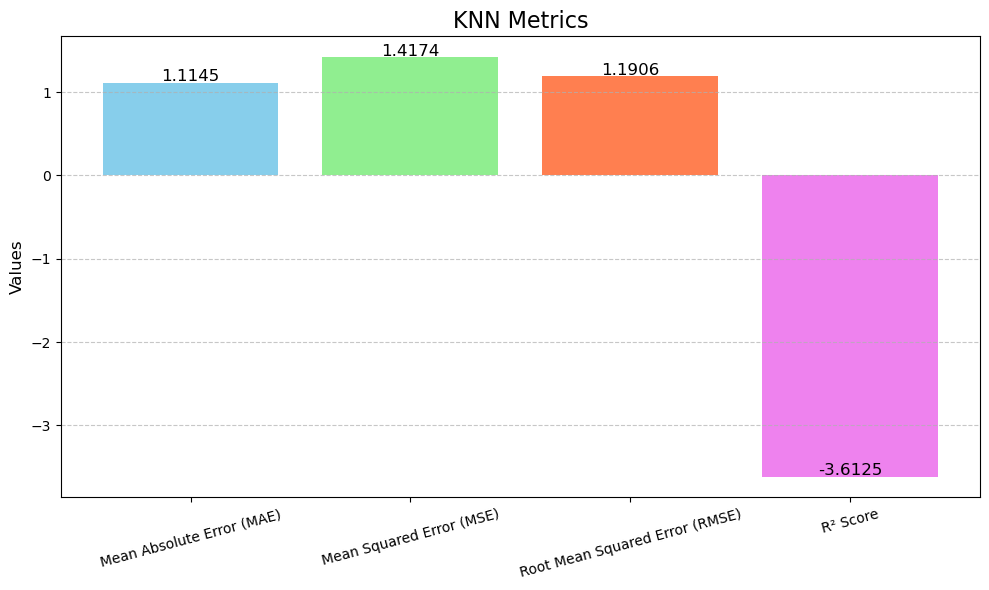

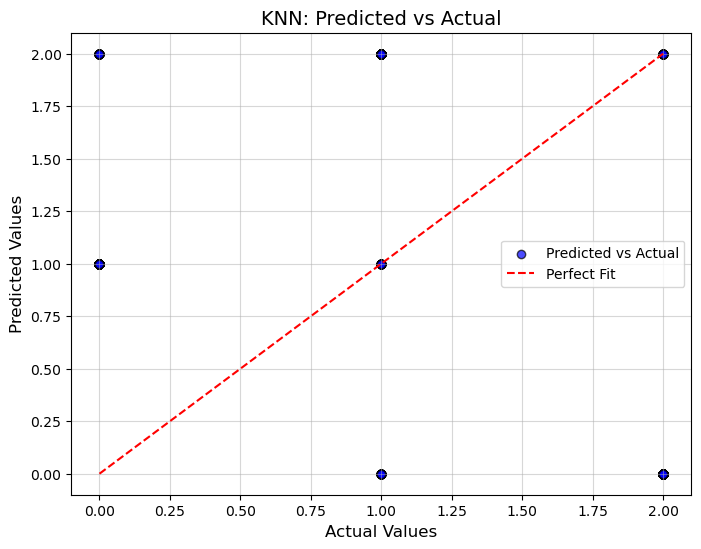

C:\Users\Arnav\AppData\Local\Temp\ipykernel_11000\1666008591.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(metrics_dict.keys(), fontsize=10, rotation=15)


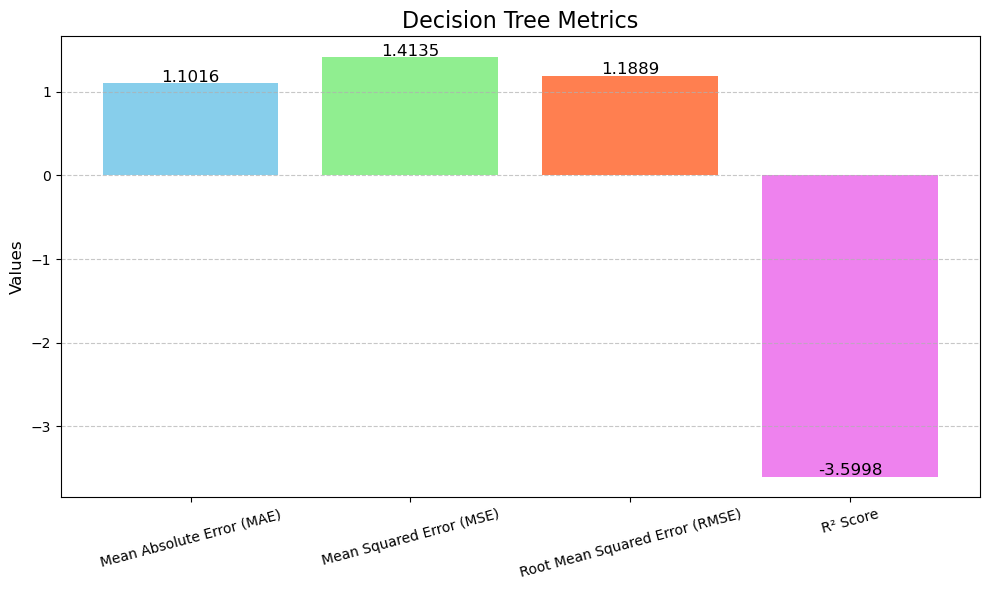

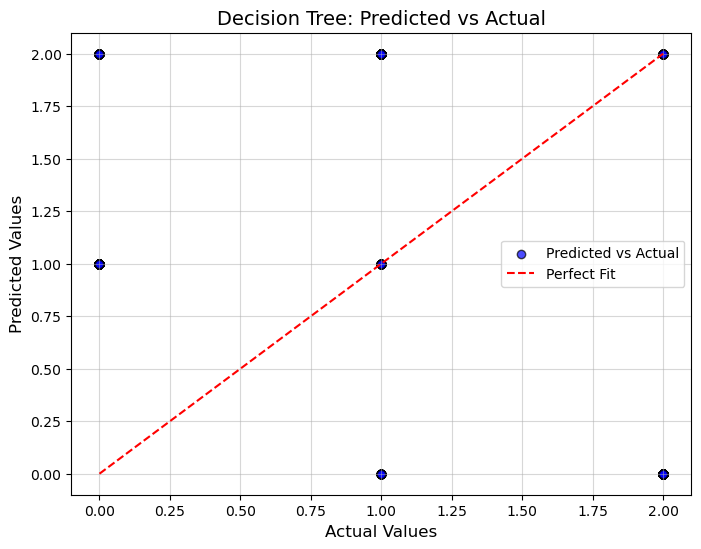

C:\Users\Arnav\AppData\Local\Temp\ipykernel_11000\1666008591.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(metrics_dict.keys(), fontsize=10, rotation=15)


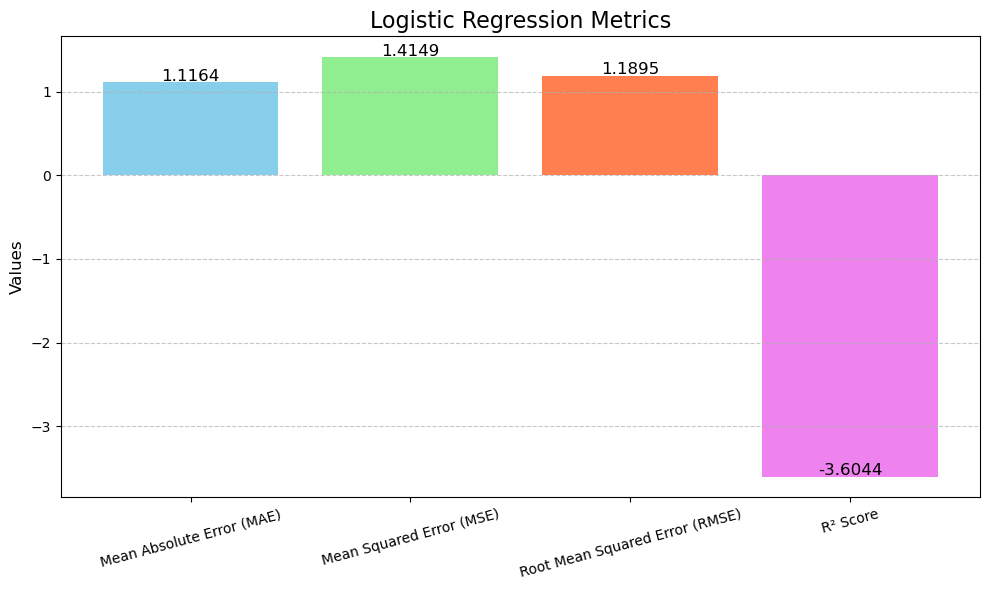

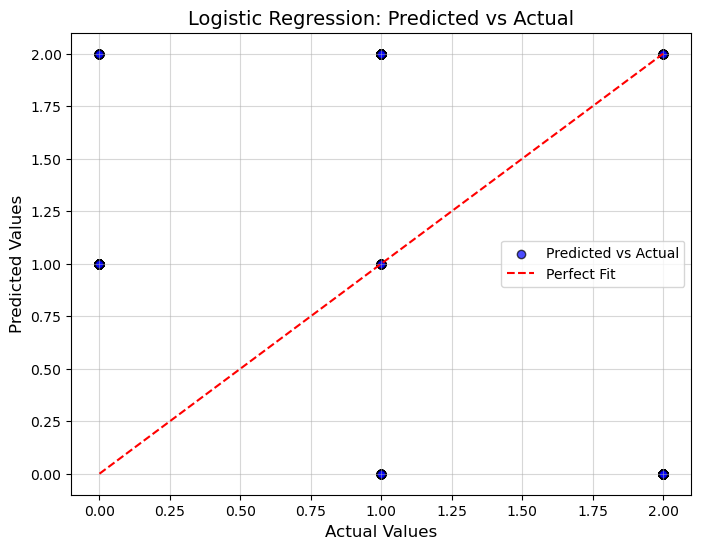

C:\Users\Arnav\AppData\Local\Temp\ipykernel_11000\1666008591.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(metrics_dict.keys(), fontsize=10, rotation=15)


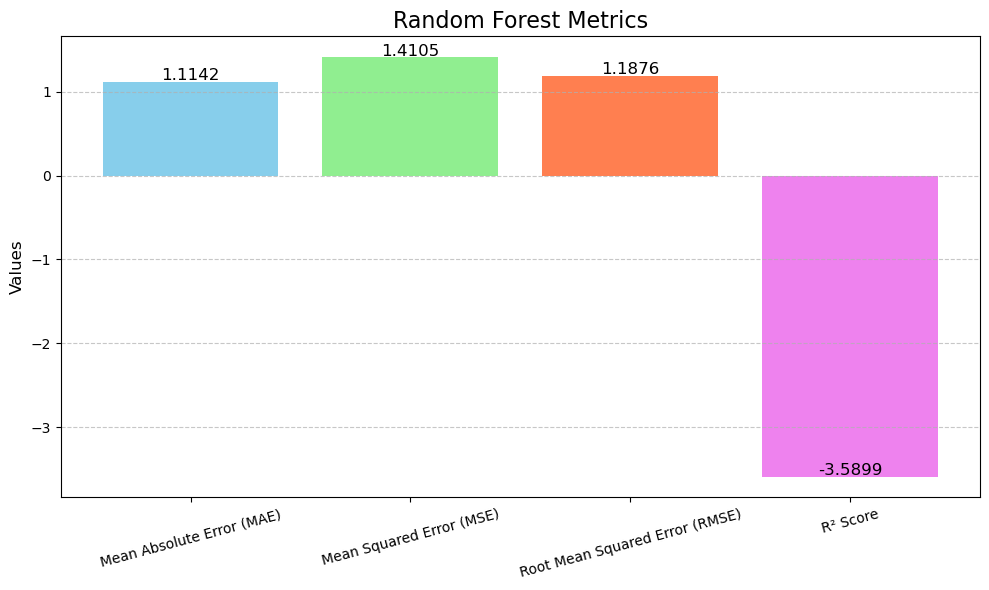

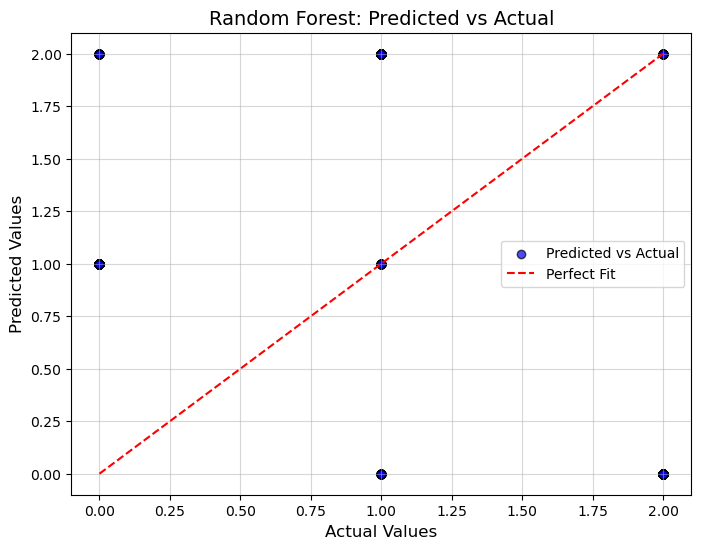

In [49]:
# Loop through each model and plot metrics and residuals
for model_name, model_metrics in metrics.items():
    # Plot bar chart of metrics
    plot_metrics_bar(model_metrics, model_name)

    # Retrieve corresponding predictions
    y_pred = model_predictions[model_name]
    
    # Plot predicted vs actual values
    plot_predictions(y_test_class_numeric, y_pred, model_name)